In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import logging

logging.basicConfig(level=logging.INFO)

In [4]:
from gfl import *

In [5]:
T = 50
p = 3

In [6]:
Y1 = np.concatenate(
    (
        np.random.normal(1, size=int(T/5)), 
        np.random.normal(5, size=int(T/2)),
        np.random.normal(3, size=T - int(T/2)-int(T/5))
    )
)


Y2 = np.concatenate(
    (
        np.random.normal(10, size=int(T/5)), 
        np.random.normal(15, size=int(T/2)),
        np.random.normal(30, size=T - int(T/2)-int(T/5))
    )
)

Y3 = np.concatenate(
    (
        np.random.normal(4, size=int(T/4)), 
        np.random.normal(8, size=int(T/2)),
        np.random.normal(1, size=T - int(T/2)-int(T/4))
    )
)

In [7]:
Y = np.column_stack((Y1, Y2, Y3))

In [34]:
Y

array([[ 0.50088684,  7.49023946,  4.82659292],
       [ 0.92116709, 10.04610663,  3.13227252],
       [ 0.44464019, 10.84176394,  4.17472986],
       [ 1.16229926,  9.63893232,  5.1377135 ],
       [ 3.12342398, 10.85210813,  3.97012479],
       [-0.46647533, 12.00729851,  2.55974753],
       [ 1.03183151,  9.74638674,  4.69833725],
       [ 1.35018898, 11.22525261,  3.47207913],
       [-1.18491647, 10.28924778,  4.38666434],
       [-0.34345571,  8.46371767,  4.88754517],
       [ 4.89172367, 14.19747851,  4.8989507 ],
       [ 3.81008152, 14.41556646,  4.58749967],
       [ 3.50653404, 15.38236103,  9.33856418],
       [ 6.77711157, 13.63323864,  7.41690582],
       [ 6.7670751 , 15.20719749,  7.43670885],
       [ 4.92505458, 15.37063179,  7.41226865],
       [ 3.48144436, 15.5036258 ,  8.38000476],
       [ 5.72663399, 15.63711564,  7.03143528],
       [ 5.43157622, 13.75861802,  8.25781071],
       [ 5.08974353, 16.24510577,  8.00865358],
       [ 5.00173709, 13.80735069,  7.788

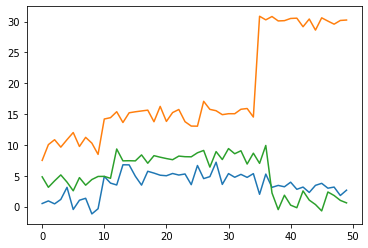

In [8]:
plt.plot(Y);

# GLF method

In [9]:
def default_weights(n):
    a = 1 + np.arange(n-1)
    w = np.sqrt(n / (a * (n-a)))
    return w

In [10]:
def left_multiply_by_xt(Y, w):
    """Fast computation for X'*Y for the group fused Lasso"""
    n, p = Y.shape
    u = np.cumsum(Y, axis=0)
    part1 = np.arange(1,n).reshape(-1,1) @ u[-1].reshape(1,-1) / n - u[:-1]
    part2 = np.array([w,]*p).transpose()
    C = np.multiply(part1, part2)
    return C

In [11]:
def compute_S():
    pass

In [12]:
def reconstruct_signal(n, act_set, beta, w, meansignal):
    """Reconstruct a piecewise constant profile from its increments"""
    a, p = beta.shape 
    # a: number of change points
    # p: dimension of signal
    
    signal = np.zeros((n, p))
    weights = np.array([w[act_set.reshape(-1,1) - 1]] * p).transpose()
    signal[act_set.flatten()] = np.multiply(beta, weights).reshape(-1, p)
    signal = np.cumsum(signal, axis=0)
    
    # set the mean signla to meansignal
    m = meansignal - np.mean(signal, axis=0)
    signal += np.array([m]*n)
    
    return signal

In [13]:
def xtx(n, A, B, w):
    """
    Compute X[:, A].T * X[:, B], where X is the design matrix of the weighted GFL
    
    Parameters:
    ----------
    n:
    A: a column vector of indices in [0, n-2]
    B: a column vector of indices in [0, n-2]
    w: (n-1) * 1 column vector of weights
    """
    
    u = np.array([A]*len(B)).transpose().reshape(len(A), len(B))
    v = np.array([B]*len(A)).reshape(len(A), len(B))
    tmp = np.multiply(n-np.maximum(u,v), w[A-1] @ w[B-1].T)/n
    g = np.multiply(np.minimum(u, v), tmp)
    return g
    

In [222]:
u = np.array([A]*len(B)).transpose().reshape(len(A), len(B))
v = np.array([B]*len(A)).reshape(len(A), len(B))


In [15]:
beta = np.array([[ -6.0745,   40.1046,  -12.4790],
   [ 5.8884 ,   8.1235 ,   4.1614],
   [ 0.9460 ,   1.5141 ,   1.4289],
   [-0.0147  ,  1.6391 ,  -1.2194]])

In [26]:
active_set = np.array([35,10,12,37]).reshape(-1,1)

In [33]:
active_set

array([[35],
       [10],
       [12],
       [37]])

In [19]:
w = default_weights(len(Y))

In [21]:
def block_coordinate_descent(beta, active_set, xty, n, w, lam):
    """Block coordinate descent over the active set of beta
    
    Parameters
    ----------
    beta: (np.array): a by p matrix as initializer
    active_set: (array): a by 1 matrix with indices of nonzero beta_t, in the range of [1, T-1]
    
    
    Returns:
            
    """
    tol = 1e-8
    maxit = 1e5
    gain = 2*tol*np.ones(a);
    
    a, p = beta.shape
    norm_beta = np.linalg.norm(beta, axis=1)
    
    if a > 0:
        
        itc = 0
        while(any(gain > tol) & (itc < maxit)):
            i = np.mod(itc, a)
            asi = active_set[i]
            
            # Compute the vector S
            XitX = xtx(n, asi, active_set, w)
            gammai = XitX.flatten()[i]
            indwithouti = np.array([k for k in range(a) if k != i])
            
            S = xty[i, :] - XitX.flatten()[indwithouti] @ beta[indwithouti, :]
            
            nS = np.linalg.norm(S)
            if nS < lam:
                newbeta = np.zeros(1, p) # If |S| < lambda, then softshriholding returns zero
            else:
                newbeta = S * (1 - lam / nS) / gammai # Otherwise, shrink S following eq.(9)
            
            # compute the gain in the objective funtion at this iteration
            new_norm_beta = np.linalg.norm(newbeta)
            gain[i] = (gammai*(norm_beta[i] + new_norm_beta)/2 + lam)*(norm_beta[i]-new_norm_beta) + \
                        S @ (newbeta - beta[i,:])
            
            if verbose:
                logging.info(f"")
                
            # update beta
            beta = np.vstack((beta, newbeta))
            norm_beta[i] = new_norm_beta
            
            itc += 1
            
    return beta
    

In [22]:
def multiplyXtXbysparse(n, active_set, beta, w):
    """"""
    a, p = beta.shape
    
    if a == 0:
        return np.zeros((n-1, p))
    else:
        beta = np.multiply(beta, np.array([w[active_set-1]]*p).transpose().reshape(-1, p))
        s = np.zeros((n-1, p))
        s[active_set.flatten()-1,:] = beta
        s = np.cumsum(s[::-1,:], 0)[::-1,:]
        u = active_set.flatten() @ beta
        
        s = s - np.array([u]*(n-1)) / n
        
        r = np.cumsum(s, 0)
        
        r = np.multiply(r, np.array([w]*p).transpose())

    return r

In [58]:
def reconstruct_signal(n, active_set, beta, weights, meansignal=None):
    """ Reconstruct a piecewise-constant profile from its increments."""
    
    a, p = beta.shape
    
    if meansignal is None:
        meansignal = np.zeros((1,p))
    
    signal = np.zeros((n, p))
    signal[active_set.flatten(), :] = np.multiply(beta, np.array([w[active_set.flatten()-1]]*p).transpose())
    signal = np.cumsum(signal, 0)
    
    # Set the mean signal to meansignal
    m = meansignal - np.mean(signal, 0)
    signal = signal + np.array([m]*n)
    
    return signal

NameError: name 'X' is not defined

In [23]:
def optimize(beta, active_set, lam, xty, y, w):
    
    tol = 1e-8
    
    it = 1
    n, p = xty.shape
    
    n += 1
    solved = False
    t_start = time.time()
    itc = 1
    meansignal = np.mean(Y, axis=0)
    res = {}
    
    while not solved:
        # optimize gfl given current active set
        beta = block_coordinate_descent(beta, active_set, xty[active_set, :], n, w, lam)

        # update active set
        nonzero_coef = np.sum(beta**2) != 0 #TODO
        active_set = active_set.flatten()[nonzero_coef]
        beta = beta[nonzero_coef, :]
        
        # Check optimality
        S = multiplyXtXbysparse(n, active_set, beta, w) - xty
        normS = np.sum(S**2, axis=1)
        
        if not active_set:
            maxnormS = np.max(normS)
            imax = np.argmax(normS)
            if maxnormS < lam**2 + tol:
                solved = True
            else:
                active_set = np.array([imax])
                beta = np.zeros((1, p))
        else:
            # for i in AS: normS[i] = lam^2
            # for i not in AS: normS[i] < lam^2
            
            lagr = max(normS[active_set-1])
            lagr = min(lagr, lam**2)
            nonas = np.setdiff1d(np.arange(1,n), active_set) - 1
            y = np.max(normS[nonas])
            i = np.argmax(normS[nonas])
            
            if (len(nonas) == 0 or y < lagr + tol):
                # optimality conditions are met; we found the global solution
                solved = True
            else:
                # Otherwise we add the block that violates most the optimality condition
                active_set = np.vstack((active_set, nonas[i]))
                beta = np.vstack((beta, np.zeros((1,p))))
          
        X = reconstruct_signal(n, active_set, beta, w, meansignal)    
        XE = X[1:, :] - X[:-1, :]
        
#         out.obj(iter) = 0.5*norm(X-Y,'fro')^2 + lambda*onetwonorm(XE');
        res['beta'] = beta
        res['active_set'] = active_set
        res['X'] = X
        
        if itc % 10 == 0 & verbose >= 1:
            print(f"Iter: {itc}")
        if time.time() - t_start > max_time
          break
        itc += 1
        t_end = time.time() - t_start
        
                         
    return res
            

In [270]:
itc = 0
beta
a, p = beta.shape
xty = C

In [190]:
beta

array([[-6.07450e+00,  4.01046e+01, -1.24790e+01],
       [ 5.88840e+00,  8.12350e+00,  4.16140e+00],
       [ 9.46000e-01,  1.51410e+00,  1.42890e+00],
       [-1.47000e-02,  1.63910e+00, -1.21940e+00]])

In [103]:
T, p = Y.shape

In [106]:
T, p = Y.shape
mean_signal = np.mean(Y, axis=0)
w = default_weights(T)
# Compute C = X'*Y
C = left_multiply_by_xt(Y, w)

In [113]:
w

array([1.01015254, 0.72168784, 0.59549133, 0.52128604, 0.47140452,
       0.43519414, 0.40756957, 0.38575837, 0.36810509, 0.35355339,
       0.34139437, 0.33113309, 0.32241294, 0.31497039, 0.3086067 ,
       0.30316953, 0.29854072, 0.29462783, 0.29135827, 0.28867513,
       0.28653413, 0.28490144, 0.28375218, 0.28306926, 0.28284271,
       0.28306926, 0.28375218, 0.28490144, 0.28653413, 0.28867513,
       0.29135827, 0.29462783, 0.29854072, 0.30316953, 0.3086067 ,
       0.31497039, 0.32241294, 0.33113309, 0.34139437, 0.35355339,
       0.36810509, 0.38575837, 0.40756957, 0.43519414, 0.47140452,
       0.52128604, 0.59549133, 0.72168784, 1.01015254])

# Optimize current lambda with a warm restart from the previous lambda
 

In [110]:
beta = np.zeros(p)
active_set = []
lam = 10
XtY = C
solved = False